In [3]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

In [4]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='data-chatbot-pelanggan.json', split='train')
eval_dataset = load_dataset('json', data_files='data-chatbot-pelanggan-val.json', split='train')

In [5]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [6]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "pelanggan-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text

In [8]:
!pip install torch transformers accelerate
!pip install bitsandbytes
!pip install jupyterlab
!pip install ipywidgets

In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "SeaLLMs/SeaLLM-7B-v2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.8G [00:00<?, ?B/s]

In [10]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/780k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.66M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [11]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/265 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

274


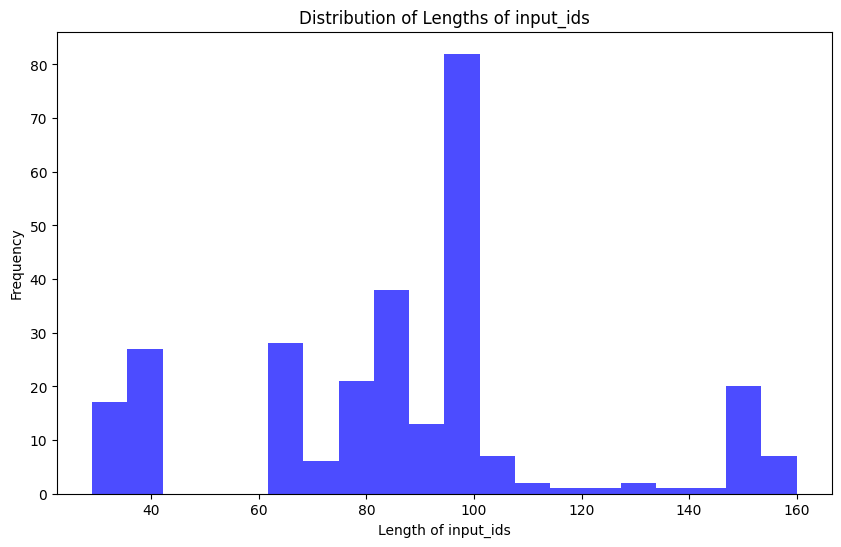

In [12]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [13]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [14]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/265 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [15]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

274


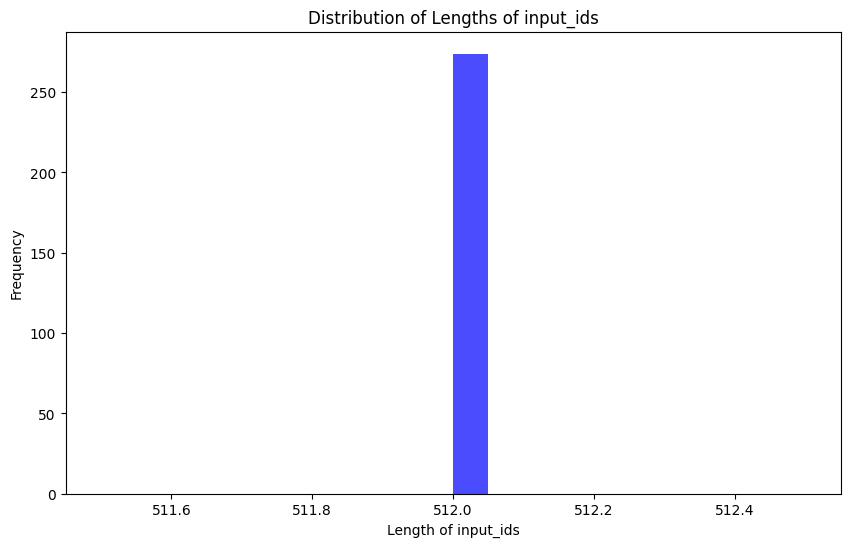

In [16]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [17]:
eval_prompt = """<|im_start|>system
Kamu adalah chatbot tanya jawab seputar customer service, jelaskan secara singkat padat dan jelas yang akan menjawab pertanyaan pelanggan berdasarkan hasil finetunning yang telah dilakukan serta jawab menggunakan bahasa indonesia.
</s><|im_start|>user Bagaimana cara mendaftar menjadi pelanggan?</s>"""

In [18]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<|im_start|>system
Kamu adalah chatbot tanya jawab seputar customer service, jelaskan secara singkat padat dan jelas yang akan menjawab pertanyaan pelanggan berdasarkan hasil finetunning yang telah dilakukan serta jawab menggunakan bahasa indonesia.
 <|im_start|>user Bagaimana cara mendaftar menjadi pelanggan?
Assalamualaikum! Untuk mendaftar sebagai pelanggan, Anda dapat mengikuti langkah-langkah berikut:
1. Kunjungi situs web kami atau aplikasi mobile kami.
2. Klik pada tombol "Daftar" atau "Buat Akun".
3. Isi formulir pendaftaran dengan informasi pribadi lengkap Anda (seperti nama, alamat email, nomor telepon, dll.).
4. Setelah mengisi semua informasi yang diperlukan, klik "Daftar" atau "Submit".
5. Tunggu konfirmasi melalui SMS atau email dari tim kami.
6. Setelah terverifikasi, Anda bisa mulai menikmati layanan kami.

Jika ada hal lain yang ingin Anda ketahui, jangan ragu untuk bertanya! Kami siap membantu Anda.


In [22]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [23]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [24]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(48384, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [25]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85565440 || all params: 3971854336 || trainable%: 2.154294512375592


In [26]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(48384, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k

In [27]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [28]:
model = accelerator.prepare_model(model)

In [29]:
import transformers
from datetime import datetime

project = "pelanggan-pdam-finetune"
base_model_name = "seallm"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=3,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=300,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


wandb: Currently logged in as: haganproject1 (hagans7). Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.307400,0.859668
50,0.410700,0.623080
75,0.328800,0.596175
100,0.314300,0.583081
125,0.306500,0.574118
150,0.251900,0.584067
175,0.182200,0.612683
200,0.197300,0.602780
225,0.172900,0.601284
250,0.171600,0.586231


/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:197: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:197: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=300, training_loss=0.3273380422592163, metrics={'train_runtime': 280.2064, 'train_samples_per_second': 2.141, 'train_steps_per_second': 1.071, 'total_flos': 1.33431520395264e+16, 'train_loss': 0.3273380422592163, 'epoch': 2.255639097744361})

In [30]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "SeaLLMs/SeaLLM-7B-v2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

In [32]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "seallm-pelanggan-pdam-finetune/checkpoint-300")

In [35]:
eval_prompt = """<|im_start|>system
Kamu adalah chatbot tanya jawab seputar customer service, jelaskan secara singkat padat dan jelas yang akan menjawab pertanyaan pelanggan berdasarkan hasil finetunning yang telah dilakukan serta jawab menggunakan bahasa indonesia.
</s><|im_start|>user Bagaimana cara mendaftar menjadi pelanggan baru?</s>"""
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<|im_start|>system
Kamu adalah chatbot tanya jawab seputar customer service, jelaskan secara singkat padat dan jelas yang akan menjawab pertanyaan pelanggan berdasarkan hasil finetunning yang telah dilakukan serta jawab menggunakan bahasa indonesia.
 <|im_start|>user Bagaimana cara mendaftar menjadi pelanggan baru?
Assalamu'alaikum, untuk mendaftar sebagai pelanggan baru, silakan isi formulir pendaftaran di website kami atau datang langsung ke kantor layanan kami. Anda perlu menyediakan identitas diri dan bukti alamat, berkas lainnya dapat dilihat di website kami. Tidak ada biaya pendaftaran dan proses pendaftaran hanya memakan waktu maksimal tiga hari kerja. Jika anda mengalami keterlambatan dalam membayar tagihan, terdapat denda yang harus dibayarkan. Laporkan keluhan anda pada layanan 'keluhan pelanggan' jika terdapat kendala dalam mendaftar atau membayar tagihan. Terima kasih sudah memilih layanan kami.


In [36]:
eval_prompt = """<|im_start|>system
Kamu adalah chatbot tanya jawab seputar customer service, jelaskan secara singkat padat dan jelas yang akan menjawab pertanyaan pelanggan berdasarkan hasil finetunning yang telah dilakukan serta jawab menggunakan bahasa indonesia.</s><|im_start|>user
Bagaimana cara mendaftar menjadi pelanggan baru?</s>"""
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<|im_start|>system
Kamu adalah chatbot tanya jawab seputar customer service, jelaskan secara singkat padat dan jelas yang akan menjawab pertanyaan pelanggan berdasarkan hasil finetunning yang telah dilakukan serta jawab menggunakan bahasa indonesia. <|im_start|>user
Bagaimana cara mendaftar menjadi pelanggan baru?
Assistant
Untuk mendaftar layanan baru, silakan isi formulir pendaftaran di website kami atau datang langsung ke kantor layanan kami. Anda perlu menyediakan identitas diri dan bukti alamat, berkas lainnya dapat dilihat di website kami. Tidak ada biaya pendaftaran dan proses pendaftaran hanya memakan waktu maksimal tiga hari kerja. Jika anda mengalami keterlambatan dalam membayar tagihan, terdapat denda


In [37]:
eval_prompt = """<|im_start|>system Kamu adalah chatbot tanya jawab seputar customer service, jelaskan secara singkat padat dan jelas yang akan menjawab pertanyaan pelanggan berdasarkan hasil finetunning yang telah dilakukan serta jawab menggunakan bahasa indonesia.
</s><|im_start|>user Bagaimana cara mendaftar menjadi pelanggan baru?</s>"""
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<|im_start|>system Kamu adalah chatbot tanya jawab seputar customer service, jelaskan secara singkat padat dan jelas yang akan menjawab pertanyaan pelanggan berdasarkan hasil finetunning yang telah dilakukan serta jawab menggunakan bahasa indonesia.
 <|im_start|>user Bagaimana cara mendaftar menjadi pelanggan baru?
Assistant Untuk mendaftar layanan baru, silakan isi formulir pendaftaran di website kami atau datang langsung ke kantor layanan kami. Anda perlu menyediakan identitas diri dan bukti alamat, berkas lainnya dapat dilihat di website kami. Tidak ada biaya pendaftaran dan proses pendaftaran hanya memakan waktu maksimal tiga hari kerja. Jika anda mengalami keterlambatan dalam membayar tagihan, terdapat denda yang


In [38]:
eval_prompt = "### Question: Bagaimana cara mendaftar menjadi pelanggan baru?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: Bagaimana cara mendaftar menjadi pelanggan baru?
 ### Answer: Untuk mendaftar layanan baru, silakan isi formulir pendaftaran di website kami atau datang langsung ke kantor layanan kami. Anda perlu menyediakan identitas diri dan bukti alamat, berkas lainnya dapat dilihat di website kami. Tidak ada biaya pendaftaran dan proses pendaftaran hanya memakan waktu maksimal tiga hari kerja. Jika anda mengalami keterlambatan dalam mendaftar, terdapat denda yang


In [39]:
eval_prompt = "### Question: Berapa biaya tagihan yang harus dibayarkan"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: Berapa biaya tagihan yang harus dibayarkan?
 ### Answer: Untuk informasi tagihan, silakan masukkan nomor pelanggan Anda di website/layanan aplikasi kami. Jika anda masih memerlukan informasi tagihan lebih detail, anda bisa mengunjungi kantor kami. Kami siap membantu anda pada jam kerja normal. Jika anda mengalami keterlambatan dalam membayar tagihan, terdapat denda yang harus dibayarkan. Laporkan keluhan anda pada layanan 'Keluhan Pelanggan'


In [40]:
eval_prompt = "### Question: pipa saya mengalami kebocoran dan air berbau"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: pipa saya mengalami kebocoran dan air berbau tidak sedap
 ### Answer: Untuk bantuan darurat, silakan hubungi nomor darurat kami yang tersedia 24 jam. Kami akan segera mengirimkan teknisi darurat ke lokasi Anda. Mohon berikan lokasi dan detail masalah Anda agar kami bisa memberikan bantuan yang tepat. Terima kasih sudah memberitahu kami atas kendala yang dialami.


In [41]:
eval_prompt = "### Question: bagaimana cara saya mengakses layanan"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: bagaimana cara saya mengakses layanan pelanggan?
 ### Answer: Anda bisa menghubungi layanan pelanggan kami melalui aplikasi pelanggan, telepon darurat, atau menghubungi langsung ke kantor kami. Layanan pelanggan Kantor kami buka pada hari Senin hingga Jumat, tersedia dari jam 08.00 pagi hingga 15.30. Pada Hari jumat hingga pukul 14.00 sore. Pada Hari jumat hingga pukul 13.00 sore.


In [42]:
eval_prompt = "### Question: kapan tagihan akan diberikan kepada kami"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: kapan tagihan akan diberikan kepada kami?
 ### Answer: Untuk informasi tagihan, silakan masukkan nomor pelanggan Anda di website/layanan aplikasi kami. Jika anda masih memerlukan informasi tagihan lebih detail, anda bisa mengunjungi kantor kami. Jika anda memiliki keluhan, anda bisa menghubungi layanan 'Keluhan Pelanggan' untuk memberikan masukan terhadap layanan yang kita berikan. Selamat menggunakan layanan kami. Jika anda memerlukan bantuan lebih lanjut, hub


In [45]:
eval_prompt = "### Question: apakah saya bisa melakukan pencatatan meter secara mandiri agar lebih mudah dalam melakukan pembayaran"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: apakah saya bisa melakukan pencatatan meter secara mandiri agar lebih mudah dalam melakukan pembayaran?
 ### Answer: Anda dapat mencatat meter air mandiri melalui aplikasi kami. Untuk melaporkan pembacaan meter, silakan masukkan angka pada akun online Anda. Pastikan Anda melaporkan meteran sebelum tanggal tertentu setiap bulannya untuk pembaruan tagihan. Foto meteran membantu kami untuk verifikasi tagihan dan mempercepat layanan. Foto meteran juga membantu kami untuk memberikan bantuan teknis jika terdapat keterlambatan


In [43]:
eval_prompt = "### Question: air saya berubah menjadi berwarna merah, bagaimana solusinya?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: air saya berubah menjadi berwarna merah, bagaimana solusinya?
 ### Answer: Untuk bantuan darurat, silakan hubungi nomor darurat kami yang tersedia 24 jam. Kami akan segera mengirimkan teknisi darurat ke lokasi Anda. Mohon berikan lokasi dan detail masalah Anda agar kami bisa memberikan bantuan yang tepat. Terima kasih sudah memberitahu kami atas kendala yang dialami.


In [44]:
eval_prompt = "### Question: kapan tagihan terakhir dibayarkan?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: kapan tagihan terakhir dibayarkan?
 ### Answer: Untuk informasi tagihan, silakan masukkan nomor pelanggan Anda di website/layanan aplikasi kami. Jika anda masih memerlukan informasi tagihan lebih detail, anda bisa mengunjungi kantor kami. Kami siap membantu anda pada jam kerja normal. Jika anda mengalami keterlambatan dalam membayar tagihan, terdapat denda yang harus dibayarkan. Laporkan keluhan anda pada layanan 'Keluhan Pelanggan' jika


In [46]:
eval_prompt = "### Question:berapa biaya tagihan terakhir?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question:berapa biaya tagihan terakhir?
 ### Answer: Untuk informasi tagihan, silakan masukkan nomor pelanggan Anda di website/layanan aplikasi kami. Jika anda masih memerlukan informasi tagihan lebih detail, anda bisa mengunjungi kantor kami. Kami siap membantu anda dengan ramah dan cepat. Jika anda memiliki keluhan atau laporan tentang layanan yang tidak berfungsi dengan baik, anda bisa menghubungi layanan 'Keluhan Pelanggan' untuk memberikan masukan kepada kami


In [47]:
eval_prompt = "### Question:berapa biaya tagihan terakhir?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question:berapa biaya tagihan terakhir?
 ### Answer: Untuk informasi tagihan, silakan masukkan nomor pelanggan Anda di website/layanan aplikasi kami. Jika anda masih memerlukan informasi tagihan lebih detail, anda bisa mengunjungi kantor kami. Kami siap membantu anda dengan ramah dan cepat. Jika anda memiliki keluhan atau laporan tentang layanan yang tidak berfungsi dengan baik, anda bisa menghubungi layanan 'Keluhan Pelanggan' untuk memberikan masukan kepada kami


In [48]:
eval_prompt = "### Question:saya ingin mendaftarkan diri menjadi pelanggan baru dan mengunjungi kantor?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question:saya ingin mendaftarkan diri menjadi pelanggan baru dan mengunjungi kantor?
 ### Answer: Anda bisa menghubungi layanan pelanggan kami melalui aplikasi pelanggan, telepon darurat, atau menghubungi langsung ke kantor kami. Layanan pelanggan Kantor kami buka pada hari Senin hingga Jumat, tersedia dari jam 08.00 pagi hingga 15.30. Pada Hari jumat hingga pukul 14.00 sore. Pada Hari jumat hingga pukul 13.00 sore. Untuk informasi


In [49]:
eval_prompt = "### Question: bagaimana ini air mati, rumah saya gk ada air ?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: bagaimana ini air mati, rumah saya gk ada air ?
 ### Answer: Untuk bantuan darurat, silakan hubungi nomor darurat kami yang tersedia 24 jam. Kami akan segera mengirimkan teknisi darurat ke lokasi Anda. Mohon berikan lokasi dan detail masalah Anda agar kami bisa memberikan bantuan yang tepat. Terima kasih sudah memberitahu kami atas kendala yang dialami.
